# Improts and setup

### Setup envirnonment 

In [405]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import necessaary libraries

In [406]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets as nets

import tempfile
from urllib.request import urlretrieve
import tarfile
import os

import json
import matplotlib.pyplot as plt

import PIL
import numpy as np

import imp

### Import custom libraries

In [407]:
import patch_utils
import image_utils

In [408]:
imp.reload(patch_utils)
imp.reload(image_utils)

<module 'image_utils' from '/Users/MichaelK./Documents/W20/209AS/Wrinkles/image_utils/__init__.py'>

# Workspace

### Load labels

In [409]:
imagenet_json, _ = urlretrieve(
    'http://www.anishathalye.com/media/2017/07/25/imagenet.json')
with open(imagenet_json) as f:
    imagenet_labels = json.load(f)### Choose an image

### Choose an image

In [410]:
img1_path = './ImageNet/467863966_a01cbd9d90.jpg'
img2_path = './ImageNet/857502810_4313e2fbd4.jpg'
img3_path = './ImageNet/81-yKbVND-L.png'
img4_path = ''
img5_path = './ImageNet/EJxGm89VUAERo8e.jpg'
img6_path = './ImageNet/flowers.jpg'

number_of_images = 3
my_raw_pillow_images = []

for i in range(number_of_images):
    my_raw_pillow_images.append(PIL.Image.open('./ImageNet/cats' + str(i+1) + '.jpg'))
    if not i== 3: my_raw_pillow_images.append(PIL.Image.open('./ImageNet/dogs' + str(i+1) + '.jpg'))
    

# get train images    
train_set = image_utils.preprocessing(my_raw_pillow_images)

# specify the patch size, mean, std
mean = 0
std = 0.4
size = 80

# get patch initializer
patch_init = np.random.normal(mean, std, (size, size, 3))
mask = np.abs(patch_init) < 1
patch_init *= mask
patch_init = patch_init.astype(np.float32)

length_of_training_set = train_set.shape[0]

### Graph setup

In [411]:
# somewhy utils do not automatically reload; so we have to do it manually
imp.reload(patch_utils)

# Allows not to reboot kernel on each initialization
tf.reset_default_graph() 


# ============================================================================= #
# ============================= declare variables ============================= #
# ============================================================================= #



# declare variable for adversarial patch
naive_patch = tf.get_variable(name="patch", initializer=patch_init, dtype=tf.float32)


# declare a placeholder for the image
train_images = tf.placeholder(name="train_images", shape=(length_of_training_set, 300, 300, 3), dtype=tf.float32)

# declare shifts
x_shifts = tf.placeholder(name="x_shifts", shape=(), dtype=tf.int32)
y_shifts = tf.placeholder(name="y_shifts", shape=(), dtype=tf.int32)

# declare learning rate
learning_rate = tf.placeholder(tf.float32, ())

# declare target class
target_class = tf.placeholder(tf.int32, ())    

# declare initializer for variables
patch_initializer = tf.variables_initializer([naive_patch])

# fold parameters
start = tf.placeholder(name="start", shape=(), dtype=tf.int32)
end = tf.placeholder(name='end', shape=(), dtype=tf.int32)
thickness = tf.placeholder(name="thickness", shape=(), dtype=tf.int32)
slope = tf.placeholder(name='slope',shape=(),dtype=tf.int32)

# rotation
degrees = tf.placeholder(name='degrees', shape=(), dtype=tf.float32)


# ============================================================================= #
# ========================== preprocessing operations ========================= #
# ============================================================================= #


# multiply patch
patch_array = patch_utils.multiply(naive_patch, train_images)

# fold patch
# folded_array = fold(patch_array, start, thickness) 

# new_folded_array, folded_array = prepareFold(patch_array, start, end, thickness, slope)
# folded_array=new_folded_array
folded_array = foldVariety(patch_array, start, end, thickness, slope)

# shift patch
# shifted_patch_array = patch_utils.shift(folded_array, x_shifts, y_shifts)
shifted_patch_array = patch_utils.shift_rotate(folded_array, x_shifts, y_shifts, degrees)


# apply patch
adv_images = patch_utils.applicator(shifted_patch_array, train_images)



# ============================================================================= #
# =============================== gradient step =============================== #
# ============================================================================= #

# get target vector
labels = tf.one_hot(np.ones((length_of_training_set)) *target_class, 1000)

# declare inception
arg_scope = nets.inception.inception_v3_arg_scope(weight_decay=0.0)
with tf.contrib.framework.arg_scope(arg_scope):
    tf_logits, end_points = tf.contrib.slim.nets.inception.inception_v3(adv_images,
                                                                        num_classes=1001,   
                                                                        is_training=False,  
                                                                        reuse = False)            
    tf_logits = tf_logits[:,1:]
    probs = tf.nn.softmax(tf_logits) 


# compute losses for each image
losses = tf.nn.softmax_cross_entropy_with_logits(logits=tf_logits, labels=[labels])    

# compute the sum of all losses
sum_loss = tf.math.reduce_sum(losses) / length_of_training_set

# update patch
optim_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(sum_loss, var_list=[naive_patch])

# ============================================================================= #
# ============================= process the result ============================ #
# ============================================================================= #



# get the result
result = adv_images



# debug function
printer = tf.print(result)



# ============================================================================= #
# =============================== declare savers ============================== #
# ============================================================================= #



# save the patch
patch_saver = tf.train.Saver([naive_patch])

# declare inception variables to restore
restore_vars = [
    var for var in tf.global_variables()
    if var.name.startswith('InceptionV3/')
]

# declate saver instance to restore inception variables
inception_saver = tf.train.Saver(restore_vars)

INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


### Save current graph

In [412]:
# use this cell if you need to save graph to corresponding folder 
writer = tf.summary.FileWriter('./graphs', tf.get_default_graph())

# Run learning 

In [413]:
num_steps = 15

# specify whether we start to learn new patch or continue from a checkpoint
load_patch = False
# specify whether to save patch
save_patch = False

my_feed_dict = {
    x_shifts: 50,
    y_shifts: 100,
    start: 0,
    end: 80,
    thickness: 10,
    slope:1,
    learning_rate: 1,
    target_class: 200,
    train_images: train_set,
    degrees: 10
}

with tf.Session() as sess:
    # load weights of the model
    inception_saver.restore(sess, './inception_v3_2016_08_28/inception_v3.ckpt')
    
    if load_patch:
        patch_saver.restore(sess, './patch_weights/45x45/patch45x45')
    else:
        # run the variable initializer operation
        sess.run(patch_initializer)    

    # make gradient updates
    for i in range(num_steps):
        # optim_step is operation, not variable; it updates x_hat 
        _, loss_value = sess.run([optim_step, sum_loss], feed_dict=my_feed_dict)

        # print loss
        if (i+1) % 5 == 0: print('step %d, loss=%g' % (i+1, loss_value))  
    
    # now let's get image with patch their value
    ex_adv_images = sess.run(result, feed_dict=my_feed_dict)
    
    # and probabilities corresponding to it
    ex_adv_probs = sess.run(probs, feed_dict=my_feed_dict)
    
    if save_patch:
        patch_saver.save(sess, './patch_weights/45x45/patch45x45')

INFO:tensorflow:Restoring parameters from ./inception_v3_2016_08_28/inception_v3.ckpt


INFO:tensorflow:Restoring parameters from ./inception_v3_2016_08_28/inception_v3.ckpt


value: 80
mask_left: [6 1 0 3]
mask_right: [6 1 70 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 0 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 1 3]
mask_right: [6 1 69 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 1 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 2 3]
mask_right: [6 1 68 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 2 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 3 3]
mask_right: [6 1 67 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 3 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 4 3]
mask_right: [6 1 66 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 4 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 5 3]
mask_right: [6 1 65 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 5 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 6 3]
mask_right: [6 1 64 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 6 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 7 3]
mas

array_images: [6 80 80 3]

value: 80
mask_left: [6 1 59 3]
mask_right: [6 1 11 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 59 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 60 3]
mask_right: [6 1 10 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 60 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 61 3]
mask_right: [6 1 9 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 61 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 62 3]
mask_right: [6 1 8 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 62 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 63 3]
mask_right: [6 1 7 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 63 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 64 3]
mask_right: [6 1 6 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 64 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 65 3]
mask_right: [6 1 5 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 65 80 3]
array_images: [6 80 80 3]

array_images: [6 80 80 3]

value: 80
mask_left: [6 1 38 3]
mask_right: [6 1 32 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 38 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 39 3]
mask_right: [6 1 31 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 39 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 40 3]
mask_right: [6 1 30 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 40 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 41 3]
mask_right: [6 1 29 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 41 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 42 3]
mask_right: [6 1 28 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 42 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 43 3]
mask_right: [6 1 27 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 43 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 44 3]
mask_right: [6 1 26 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 44 80 3]
array_images: [6 80 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

--- Logging error ---
Error in sys.excepthook:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



Original exception was:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

--- Logging error ---
Error in sys.excepthook:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occur

Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ZMQError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1148, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 316, in wrapped
    return f(*args, **kwargs)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 350, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/Users/MichaelK./opt/miniconda3/lib/python3.7/inspect.py", line 1502, in getinnerframes
    f

Error in sys.excepthook:
Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ZMQError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2047, in showtraceback
    value, tb, tb_offset=tb_offset)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1415, in structured_traceback
    self, etype, value, tb, tb_offset, number_of_lines_of_context)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1315, in structured_traceback
    self, etype, value, tb, tb_offset, number_of_lines_of_context
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/c

array_images: [6 80 80 3]

value: 80
mask_left: [6 1 50 3]
mask_right: [6 1 20 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 50 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 51 3]
mask_right: [6 1 19 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 51 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 52 3]
mask_right: [6 1 18 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 52 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 53 3]
mask_right: [6 1 17 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 53 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 54 3]
mask_right: [6 1 16 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 54 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 55 3]
mask_right: [6 1 15 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 55 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 56 3]
mask_right: [6 1 14 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 56 80 3]
array_images: [6 80 

array_images: [6 80 80 3]

value: 80
mask_left: [6 1 29 3]
mask_right: [6 1 41 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 29 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 30 3]
mask_right: [6 1 40 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 30 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 31 3]
mask_right: [6 1 39 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 31 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 32 3]
mask_right: [6 1 38 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 32 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 33 3]
mask_right: [6 1 37 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 33 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 34 3]
mask_right: [6 1 36 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 34 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 35 3]
mask_right: [6 1 35 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 35 80 3]
array_images: [6 80 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

--- Logging error ---
Error in sys.excepthook:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



Original exception was:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

--- Logging error ---
Error in sys.excepthook:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occur

Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ZMQError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1148, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 316, in wrapped
    return f(*args, **kwargs)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 350, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/Users/MichaelK./opt/miniconda3/lib/python3.7/inspect.py", line 1502, in getinnerframes
    f

Error in sys.excepthook:
Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ZMQError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2047, in showtraceback
    value, tb, tb_offset=tb_offset)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1415, in structured_traceback
    self, etype, value, tb, tb_offset, number_of_lines_of_context)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1315, in structured_traceback
    self, etype, value, tb, tb_offset, number_of_lines_of_context
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/c


value: 80
mask_left: [6 1 62 3]
mask_right: [6 1 8 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 62 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 63 3]
mask_right: [6 1 7 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 63 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 64 3]
mask_right: [6 1 6 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 64 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 65 3]
mask_right: [6 1 5 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 65 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 66 3]
mask_right: [6 1 4 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 66 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 67 3]
mask_right: [6 1 3 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 67 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 68 3]
mask_right: [6 1 2 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 68 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

--- Logging error ---
Error in sys.excepthook:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



Original exception was:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

--- Logging error ---
Error in sys.excepthook:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occur

Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ZMQError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1148, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 316, in wrapped
    return f(*args, **kwargs)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 350, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/Users/MichaelK./opt/miniconda3/lib/python3.7/inspect.py", line 1502, in getinnerframes
    f

Error in sys.excepthook:
Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
AttributeError: 'ZMQError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2047, in showtraceback
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1415, in structured_traceback
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1315, in structured_traceback
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1183, in structured_traceback
TypeError: can only concatenate str (not "list") to str

Original exception was:
Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/py

Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ZMQError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1148, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 316, in wrapped
    return f(*args, **kwargs)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 350, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/Users/MichaelK./opt/miniconda3/lib/python3.7/inspect.py", line 1502, in getinnerframes
    f

Error in sys.excepthook:
Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ZMQError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2047, in showtraceback
    value, tb, tb_offset=tb_offset)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1415, in structured_traceback
    self, etype, value, tb, tb_offset, number_of_lines_of_context)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1315, in structured_traceback
    self, etype, value, tb, tb_offset, number_of_lines_of_context
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/c

mask_left: [6 1 36 3]
mask_right: [6 1 34 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 36 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 37 3]
mask_right: [6 1 33 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 37 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 38 3]
mask_right: [6 1 32 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 38 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 39 3]
mask_right: [6 1 31 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 39 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 40 3]
mask_right: [6 1 30 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 40 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 41 3]
mask_right: [6 1 29 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 41 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 42 3]
mask_right: [6 1 28 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 42 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 43 3


value: 80
mask_left: [6 1 15 3]
mask_right: [6 1 55 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 15 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 16 3]
mask_right: [6 1 54 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 16 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 17 3]
mask_right: [6 1 53 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 17 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 18 3]
mask_right: [6 1 52 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 18 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 19 3]
mask_right: [6 1 51 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 19 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 20 3]
mask_right: [6 1 50 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 20 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 21 3]
mask_right: [6 1 49 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 21 80 3]
array_images: [6 80 80 3]

value: 80
mask_left

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

--- Logging error ---
Error in sys.excepthook:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



Original exception was:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

--- Logging error ---
Error in sys.excepthook:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occur

Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ZMQError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1148, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 316, in wrapped
    return f(*args, **kwargs)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 350, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/Users/MichaelK./opt/miniconda3/lib/python3.7/inspect.py", line 1502, in getinnerframes
    f

Error in sys.excepthook:
Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ZMQError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2047, in showtraceback
    value, tb, tb_offset=tb_offset)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1415, in structured_traceback
    self, etype, value, tb, tb_offset, number_of_lines_of_context)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1315, in structured_traceback
    self, etype, value, tb, tb_offset, number_of_lines_of_context
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/c

value: 80
mask_left: [6 1 48 3]
mask_right: [6 1 22 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 48 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 49 3]
mask_right: [6 1 21 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 49 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 50 3]
mask_right: [6 1 20 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 50 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 51 3]
mask_right: [6 1 19 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 51 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 52 3]
mask_right: [6 1 18 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 52 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 53 3]
mask_right: [6 1 17 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 53 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 54 3]
mask_right: [6 1 16 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 54 80 3]
array_images: [6 80 80 3]

value: 80
mask_left:

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ZMQError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1148, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 316, in wrapped
    return f(*args, **kwargs)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 350, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/Users/MichaelK./opt/miniconda3/lib/python3.7/inspect.py", line 1502, in getinnerframes
    f

Error in sys.excepthook:
Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
AttributeError: 'ZMQError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2047, in showtraceback
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1415, in structured_traceback
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1315, in structured_traceback
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1183, in structured_traceback
TypeError: can only concatenate str (not "list") to str

Original exception was:
Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/py

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ZMQError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1148, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 316, in wrapped
    return f(*args, **kwargs)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 350, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/Users/MichaelK./opt/miniconda3/lib/python3.7/inspect.py", line 1502, in getinnerframes
    f

Error in sys.excepthook:
Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ZMQError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2047, in showtraceback
    value, tb, tb_offset=tb_offset)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1415, in structured_traceback
    self, etype, value, tb, tb_offset, number_of_lines_of_context)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1315, in structured_traceback
    self, etype, value, tb, tb_offset, number_of_lines_of_context
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/c

step 5, loss=8.53097
value: 80
mask_left: [6 1 0 3]
mask_right: [6 1 70 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 0 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 1 3]
mask_right: [6 1 69 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 1 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 2 3]
mask_right: [6 1 68 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 2 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 3 3]
mask_right: [6 1 67 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 3 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 4 3]
mask_right: [6 1 66 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 4 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 5 3]
mask_right: [6 1 65 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 5 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 6 3]
mask_right: [6 1 64 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 6 80 3]
array_images: [6 80 80 3]

value: 80
mas

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

--- Logging error ---
Error in sys.excepthook:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



Original exception was:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

--- Logging error ---
Error in sys.excepthook:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occur

Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ZMQError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1148, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 316, in wrapped
    return f(*args, **kwargs)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 350, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/Users/MichaelK./opt/miniconda3/lib/python3.7/inspect.py", line 1502, in getinnerframes
    f

Error in sys.excepthook:
Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ZMQError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2047, in showtraceback
    value, tb, tb_offset=tb_offset)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1415, in structured_traceback
    self, etype, value, tb, tb_offset, number_of_lines_of_context)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1315, in structured_traceback
    self, etype, value, tb, tb_offset, number_of_lines_of_context
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/c


value: 80
mask_left: [6 1 35 3]
mask_right: [6 1 35 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 35 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 36 3]
mask_right: [6 1 34 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 36 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 37 3]
mask_right: [6 1 33 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 37 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 38 3]
mask_right: [6 1 32 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 38 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 39 3]
mask_right: [6 1 31 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 39 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 40 3]
mask_right: [6 1 30 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 40 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 41 3]
mask_right: [6 1 29 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 41 80 3]
array_images: [6 80 80 3]

value: 80
mask_left

array_images: [6 80 80 3]

value: 80
mask_left: [6 1 14 3]
mask_right: [6 1 56 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 14 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 15 3]
mask_right: [6 1 55 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 15 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 16 3]
mask_right: [6 1 54 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 16 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 17 3]
mask_right: [6 1 53 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 17 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 18 3]
mask_right: [6 1 52 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 18 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 19 3]
mask_right: [6 1 51 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 19 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 20 3]
mask_right: [6 1 50 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 20 80 3]
array_images: [6 80 

array_images_top: [6 72 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 73 3]
mask_right: [6 1 0 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 73 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 74 3]
mask_right: [6 1 0 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 74 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 75 3]
mask_right: [6 1 0 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 75 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 76 3]
mask_right: [6 1 0 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 76 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 77 3]
mask_right: [6 1 0 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 77 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 78 3]
mask_right: [6 1 0 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 78 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 79 3]
mask_right: [6 1 0 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 79 80 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

--- Logging error ---
Error in sys.excepthook:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



Original exception was:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

--- Logging error ---
Error in sys.excepthook:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occur

Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ZMQError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1148, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 316, in wrapped
    return f(*args, **kwargs)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 350, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/Users/MichaelK./opt/miniconda3/lib/python3.7/inspect.py", line 1502, in getinnerframes
    f

Error in sys.excepthook:
Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ZMQError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2047, in showtraceback
    value, tb, tb_offset=tb_offset)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1415, in structured_traceback
    self, etype, value, tb, tb_offset, number_of_lines_of_context)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1315, in structured_traceback
    self, etype, value, tb, tb_offset, number_of_lines_of_context
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/c

mask_right: [6 1 18 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 52 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 53 3]
mask_right: [6 1 17 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 53 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 54 3]
mask_right: [6 1 16 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 54 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 55 3]
mask_right: [6 1 15 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 55 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 56 3]
mask_right: [6 1 14 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 56 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 57 3]
mask_right: [6 1 13 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 57 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 58 3]
mask_right: [6 1 12 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 58 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 59 3]
mask_right: [6 1 11 

mask_left: [6 1 31 3]
mask_right: [6 1 39 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 31 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 32 3]
mask_right: [6 1 38 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 32 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 33 3]
mask_right: [6 1 37 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 33 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 34 3]
mask_right: [6 1 36 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 34 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 35 3]
mask_right: [6 1 35 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 35 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 36 3]
mask_right: [6 1 34 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 36 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 37 3]
mask_right: [6 1 33 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 37 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 38 3


value: 80
mask_left: [6 1 10 3]
mask_right: [6 1 60 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 10 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 11 3]
mask_right: [6 1 59 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 11 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 12 3]
mask_right: [6 1 58 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 12 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 13 3]
mask_right: [6 1 57 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 13 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 14 3]
mask_right: [6 1 56 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 14 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 15 3]
mask_right: [6 1 55 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 15 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 16 3]
mask_right: [6 1 54 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 16 80 3]
array_images: [6 80 80 3]

value: 80
mask_left

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

--- Logging error ---
Error in sys.excepthook:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



Original exception was:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

--- Logging error ---
Error in sys.excepthook:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occur

Error in sys.excepthook:
Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ZMQError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2047, in showtraceback
    value, tb, tb_offset=tb_offset)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1415, in structured_traceback
    self, etype, value, tb, tb_offset, number_of_lines_of_context)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1315, in structured_traceback
    self, etype, value, tb, tb_offset, number_of_lines_of_context
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/c

Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ZMQError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1148, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 316, in wrapped
    return f(*args, **kwargs)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 350, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/Users/MichaelK./opt/miniconda3/lib/python3.7/inspect.py", line 1502, in getinnerframes
    f

Too many open files


array_images_top: [6 63 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 64 3]
mask_right: [6 1 6 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 64 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 65 3]
mask_right: [6 1 5 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 65 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 66 3]
mask_right: [6 1 4 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 66 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 67 3]
mask_right: [6 1 3 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 67 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 68 3]
mask_right: [6 1 2 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 68 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 69 3]
mask_right: [6 1 1 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 69 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 70 3]
mask_right: [6 1 0 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 70 80 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

--- Logging error ---
Error in sys.excepthook:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



Original exception was:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

--- Logging error ---
Error in sys.excepthook:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occur

ZMQError: Too many open files

mask_right: [6 1 40 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 30 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 31 3]
mask_right: [6 1 39 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 31 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 32 3]
mask_right: [6 1 38 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 32 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 33 3]
mask_right: [6 1 37 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 33 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 34 3]
mask_right: [6 1 36 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 34 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 35 3]
mask_right: [6 1 35 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 35 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 36 3]
mask_right: [6 1 34 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 36 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 37 3]
mask_right: [6 1 33 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

--- Logging error ---
Error in sys.excepthook:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



Original exception was:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

--- Logging error ---
Error in sys.excepthook:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occur

ZMQError: Too many open files

mask_fill_final: [6 1 80 3]
array_images_top: [6 77 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 78 3]
mask_right: [6 1 0 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 78 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 79 3]
mask_right: [6 1 0 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 79 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 0 3]
mask_right: [6 1 70 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 0 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 1 3]
mask_right: [6 1 69 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 1 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 2 3]
mask_right: [6 1 68 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 2 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 3 3]
mask_right: [6 1 67 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 3 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 4 3]
mask_right: [6 1 66 3]
mask_fill_final: [6 1 80 3]
arr

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

--- Logging error ---
Error in sys.excepthook:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



Original exception was:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

--- Logging error ---
Error in sys.excepthook:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occur

Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ZMQError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1148, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 316, in wrapped
    return f(*args, **kwargs)
  File "/Users/MichaelK./.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 350, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/Users/MichaelK./opt/miniconda3/lib/python3.7/inspect.py", line 1502, in getinnerframes
    f

mask_left: [6 1 42 3]
mask_right: [6 1 28 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 42 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 43 3]
mask_right: [6 1 27 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 43 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 44 3]
mask_right: [6 1 26 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 44 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 45 3]
mask_right: [6 1 25 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 45 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 46 3]
mask_right: [6 1 24 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 46 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 47 3]
mask_right: [6 1 23 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 47 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 48 3]
mask_right: [6 1 22 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 48 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 49 3

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

--- Logging error ---
Error in sys.excepthook:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



Original exception was:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

--- Logging error ---
Error in sys.excepthook:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occur

array_images: [6 80 80 3]

value: 80
mask_left: [6 1 52 3]
mask_right: [6 1 18 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 52 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 53 3]
mask_right: [6 1 17 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 53 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 54 3]
mask_right: [6 1 16 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 54 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 55 3]
mask_right: [6 1 15 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 55 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 56 3]
mask_right: [6 1 14 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 56 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 57 3]
mask_right: [6 1 13 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 57 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 58 3]
mask_right: [6 1 12 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 58 80 3]
array_images: [6 80 

mask_fill_final: [6 1 80 3]
array_images_top: [6 10 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 11 3]
mask_right: [6 1 59 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 11 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 12 3]
mask_right: [6 1 58 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 12 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 13 3]
mask_right: [6 1 57 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 13 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 14 3]
mask_right: [6 1 56 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 14 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 15 3]
mask_right: [6 1 55 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 15 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 16 3]
mask_right: [6 1 54 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 16 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 17 3]
mask_right: [6 1 53 3]
mask_fill_final: [6 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

--- Logging error ---
Error in sys.excepthook:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



Original exception was:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

--- Logging error ---
Error in sys.excepthook:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occur

ZMQError: Too many open files

array_images_top: [6 34 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 35 3]
mask_right: [6 1 35 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 35 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 36 3]
mask_right: [6 1 34 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 36 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 37 3]
mask_right: [6 1 33 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 37 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 38 3]
mask_right: [6 1 32 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 38 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 39 3]
mask_right: [6 1 31 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 39 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 40 3]
mask_right: [6 1 30 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 40 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 41 3]
mask_right: [6 1 29 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6

mask_right: [6 1 9 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 61 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 62 3]
mask_right: [6 1 8 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 62 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 63 3]
mask_right: [6 1 7 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 63 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 64 3]
mask_right: [6 1 6 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 64 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 65 3]
mask_right: [6 1 5 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 65 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 66 3]
mask_right: [6 1 4 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 66 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 67 3]
mask_right: [6 1 3 3]
mask_fill_final: [6 1 80 3]
array_images_top: [6 67 80 3]
array_images: [6 80 80 3]

value: 80
mask_left: [6 1 68 3]
mask_right: [6 1 2 3]
mask_

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

--- Logging error ---
Error in sys.excepthook:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occurred:



Original exception was:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

--- Logging error ---
Error in sys.excepthook:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:



During handling of the above exception, another exception occur

Tibetan terrier, chrysanthemum dog


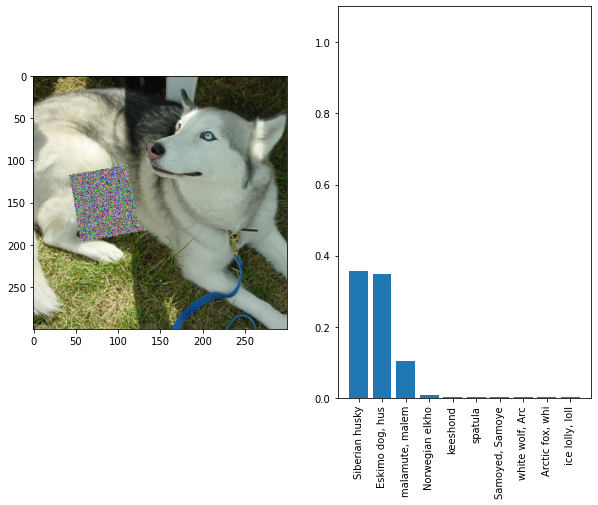

In [414]:
#image_utils.plot_adversarial_image(ex_adv_image.reshape(300, 300, 3))

# print(ex_adv_images[3][50])

image_num = 1
print(imagenet_labels[200])
post_proc_adv_images = image_utils.postprocessing(ex_adv_images)
image_utils.show_probs(post_proc_adv_images[image_num], ex_adv_probs[image_num], 
                       imagenet_labels, target_class=200)

In [389]:
@tf.function
def prepareFold(array_images, starting, ending, thickness, slope):
    
    mask_fill_thickness = tf.zeros([tf.shape(array_images)[0], tf.shape(array_images)[1], thickness, 3], 
                               tf.float32, name='mask_fill_thickness')
    
    new_array_images = array_images
    
    ending_point = starting+ending*slope
    ending_point = tf.cond(ending_point>tf.shape(array_images)[2],
                          lambda: tf.shape(array_images)[2],
                          lambda: ending_point)
    pixel_shifts = (ending_point-(tf.shape(array_images)[2]-thickness))/slope + 1
    
    pixel_shifts = tf.cast(pixel_shifts/3, dtype=tf.int32)
    
    i = tf.constant(0, dtype=tf.int32)
    
    while_condition1 = lambda i, new_array_images: tf.less(i, pixel_shifts)
    def body1(i, new_array_images):
        
        mask_left = tf.slice(array_images, [0, i, 0, 0], [-1, 1, starting+i*slope, -1])
        mask_left1 = tf.slice(array_images, [0, tf.shape(array_images)[1]-1-pixel_shifts+i, 0, 0], 
                              [-1, 1, tf.shape(array_images)[2]-1-i*slope, -1])
        tf.print("mask_left1: ", tf.shape(mask_left1))
        
        mask_negatives = tf.ones([tf.shape(array_images)[0], 1, 
                                  tf.shape(array_images)[2]-tf.shape(mask_left)[2], 3],tf.float32)
        mask_negatives1 = tf.ones([tf.shape(array_images)[0], 1, 
                                  tf.shape(array_images)[2]-tf.shape(mask_left1)[2], 3],tf.float32)
        tf.print("mask_negatives1: ", tf.shape(mask_negatives1))
        
        mask_negatives = tf.subtract(mask_negatives, 3)
        mask_negatives1 = tf.subtract(mask_negatives1, 3)
        
        mask_fill_final = tf.concat([mask_left, mask_negatives], axis=2)
        mask_fill_final1 = tf.concat([mask_left1, mask_negatives1], axis=2)
        
        # Concatenating the new row into the array_images
        
        new_array_images_top = tf.slice(new_array_images, [0, 0, 0, 0], [-1, i, -1, -1])
        tf.print("new_array_images_top: ",tf.shape(new_array_images_top))
        new_array_images_mid = tf.slice(new_array_images, [0, i+1, 0, 0], 
                                         [-1, tf.shape(array_images)[1]-1-pixel_shifts, -1, -1])
        
        tf.print("new_array_images_mid: ",tf.shape(new_array_images_mid))
        
        # new_array_images_bottom = tf.slice(new_array_images, [0, i+1, 0, 0], [-1, -1, -1, -1])
        new_array_images_bottom1 = tf.slice(new_array_images, 
                                            [0, tf.shape(array_images)[1]-pixel_shifts+i+1, 0, 0], 
                                            [-1, -1, -1, -1])
        
        tf.print("new_array_images_bottom1: ",tf.shape(new_array_images_bottom1))
        
        new_array_images = tf.concat([new_array_images_top, mask_fill_final, 
                                      new_array_images_mid, mask_fill_final1, new_array_images_bottom1], axis=1)
        tf.print("new_array_images: ", tf.shape(new_array_images))
        tf.print()
        
        return [tf.add(i, 1), new_array_images]

    # do the loop:
    i, new_array_images = tf.while_loop(while_condition1, body1, [i, new_array_images], 
                              shape_invariants=[i.get_shape(),tf.TensorShape(None)])
    tf.print(tf.shape(new_array_images))
    
    return new_array_images, array_images
    

In [378]:
input1 = [
    [[11, 12, 13], [14, 15, 16]],
    [[21, 22, 23], [24, 25, 26]],
    [[31, 32, 33], [34, 35, 36]],
    [[41, 42, 43], [44, 45, 46]],
    [[51, 52, 53], [54, 55, 56]],
]
input1 = np.array(input1)
print(input1[:,:,0])

[[11 14]
 [21 24]
 [31 34]
 [41 44]
 [51 54]]


In [276]:
@tf.function
def foldFinal(new_array_images, array_images, starting, ending, thickness, slope):
    
    ending_point = starting+ending*slope
    ending_point = tf.cond(ending_point>tf.shape(array_images)[2],
                          lambda: tf.shape(array_images)[2],
                          lambda: ending_point)
    pixel_shifts = (ending_point-(tf.shape(array_images)[2]-thickness))/slope + 1
    
    pixel_shifts = tf.cast(pixel_shifts, dtype=tf.int32)
    
    i = tf.constant(0, dtype=tf.int32)
    
    while_condition = lambda i, new_array_images: tf.less(i, ending-pixel_shifts)
    def body(i, new_array_images):
        mask_left = tf.slice(array_images, [0, i+pixel_shifts, 0, 0], [-1, 1, starting+(i+pixel_shifts)*slope, -1])

        mask_right = tf.cond(starting+i*slope+thickness<=tf.shape(array_images)[2],
                             lambda: tf.slice(array_images, [0, i, starting+i*slope+thickness, 0], 
                                              [-1, 1, -1, -1]),
                             lambda: tf.slice(array_images, [0, i, tf.shape(array_images)[2], 0], 
                                              [-1, 1, -1, -1]))
        
        mask_negatives = tf.cond(starting+(i+pixel_shifts)*slope+thickness<=tf.shape(array_images)[2],
                                 lambda: tf.ones([tf.shape(array_images)[0], 1, thickness, 3],tf.float32),
                                 lambda: tf.ones([tf.shape(array_images)[0], 1, 
                                                  tf.shape(array_images)[2]-starting-(i+pixel_shifts)*slope,3],
                                                 tf.float32))
        mask_negatives = tf.subtract(mask_negatives, 3)
        
        mask_fill_final = tf.concat([mask_left, mask_right, mask_negatives], axis=2)
        
        array_images_top = tf.slice(array_images, [0, pixel_shifts, 0, 0], [-1, i+pixel_shifts, -1, -1])
        
        array_images_bottom = tf.slice(array_images, [0, pixel_shifts+i+1, 0, 0], [-1, -1, -1, -1])
        
        new_array_images = tf.concat([array_images_top, mask_fill_final, array_images_bottom], axis=1)

        return [tf.add(i, 1), array_images]

    # do the loop:
    i, new_array_images = tf.while_loop(while_condition, body, [i, new_array_images], 
                              shape_invariants=[i.get_shape(),tf.TensorShape(None)])
    return new_array_images

In [400]:
@tf.function
def foldVariety(array_images, starting, ending, thickness, slope):
    
    mask_fill_thickness = tf.zeros([tf.shape(array_images)[0], tf.shape(array_images)[1], thickness, 3], 
                               tf.float32, name='mask_fill_thickness')
    
    i = tf.constant(0, dtype=tf.int32)
    
    while_condition = lambda i, array_images: tf.less(i,ending)
    def body(i, array_images):
        tf.print("value:", starting+(ending-starting)*slope)
        mask_left = tf.slice(array_images, [0, i, 0, 0], [-1, 1, starting+i*slope, -1])
        tf.print("mask_left:", tf.shape(mask_left))
        
        mask_right = tf.cond(starting+i*slope+thickness<=tf.shape(array_images)[2],
                             lambda: tf.slice(array_images, [0, i, starting+i*slope+thickness, 0], [-1, 1, -1, -1]),
                             lambda: tf.slice(array_images, [0, i, tf.shape(array_images)[2], 0], [-1, 1, -1, -1]))
        
        # tf.print("mask_right_start:", mask_right_start)
        
        tf.print("mask_right:", tf.shape(mask_right))
        
        mask_negatives = tf.cond(starting+i*slope+thickness<=tf.shape(array_images)[2],
                                 lambda: tf.ones([tf.shape(array_images)[0], 1, thickness, 3],tf.float32),
                                 lambda: tf.ones([tf.shape(array_images)[0], 1, 
                                                  tf.shape(array_images)[2]-starting-i*slope,3],tf.float32))
        mask_negatives = tf.subtract(mask_negatives, 3)
        
        # tf.print("mask_negatives:", tf.shape(mask_negatives))
        
        mask_fill_final = tf.concat([mask_left, mask_right, mask_negatives], axis=2)
        tf.print("mask_fill_final:", tf.shape(mask_fill_final))
        
        # Concatenating the new row into the array_images
        
        array_images_top = tf.slice(array_images, [0, 0, 0, 0], [-1, i, -1, -1])
        
        tf.print("array_images_top:", tf.shape(array_images_top))
        
        array_images_bottom = tf.slice(array_images, [0, i+1, 0, 0], [-1, -1, -1, -1])
        
        array_images = tf.concat([array_images_top, mask_fill_final, array_images_bottom], axis=1)
        
        # array_images = tf.concat([array_images_top, mask_fill_final, array_images_bottom], axis=1)
        
        tf.print("array_images:", tf.shape(array_images))
        tf.print()

        return [tf.add(i, 1), array_images]

    # do the loop:
    i, array_images = tf.while_loop(while_condition, body, [i, array_images], 
                              shape_invariants=[i.get_shape(),tf.TensorShape(None)])
    
    return array_images
    